In [57]:
# imports
import numpy as np
import pandas as pd
import networkx as nx
from scipy.misc import comb
import scipy.stats as ss
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from __future__ import division

import json
from sys import maxint
from scipy.special import binom
from IPython.display import display, HTML
from sklearn.cross_validation import KFold


In [58]:
# Inline all plots to cell outputs
%matplotlib inline

In [59]:
# Distance functions and utility functions by Jon Bloom

def load_table(sample):
    f = open(sample + '.table.txt', 'r')
    read_groups = eval(f.readline())
    libraries = eval(f.readline())
    n_reads = eval(f.readline())
    n_reads_removed = eval(f.readline())
    table = eval(f.readline())
    f.close()
    return read_groups, libraries, n_reads, n_reads_removed, table

def group_sizes(table, n_groups):
    '''Returns vector v where v[i] is count of reads in group i.'''
    rg_sizes = np.zeros(n_groups, dtype=int)
    for item in table.items():
        for i in item[0]:
            rg_sizes[i] += item[1]
    return rg_sizes

def remove_empty_groups(read_groups, libraries, table):
    n_groups = len(read_groups)
    rg_sizes = group_sizes(table, n_groups)
    if np.prod(rg_sizes != 0):
        return read_groups, libraries, table
    else:
        groups = [read_groups[i] for i in range(n_groups) if rg_sizes[i] != 0]
        libs = [libraries[i] for i in range(n_groups) if rg_sizes[i] != 0]
        new_num_of_old_num = {}
        current_num = 0
        for i in range(n_groups):
            new_num_of_old_num[i] = current_num
            if rg_sizes[i] != 0:
                current_num += 1
        new_table = Counter()
        for item in table.items():
            new_key = tuple(map(lambda x : new_num_of_old_num[x], list(item[0])))
            new_table.update({new_key : item[1]})
        return groups, libs, new_table
    
def library_nums(libraries):
    n_groups = len(libraries)
    num_of_library = {}
    current_num = 0
    for i in xrange(n_groups):
        if libraries[i] not in num_of_library.keys(): #change to set_default
            num_of_library[libraries[i]] = current_num
            current_num += 1
    return np.array([num_of_library[libraries[i]] for i in xrange(n_groups)])

def library_colors(lib_nums):
    #lib_color = plt.cm.Set1(lib_nums / (n_libraries + 1))
    color_of_num = {0 : 'r', 1 : 'b', 2 : 'g', 3 : 'k', 4 : 'y', 5 : 'm', 6 : 'c'}
    return [color_of_num[lib_num % 5] for lib_num in lib_nums]

def library_matrix(lib_nums, n_groups):
    lib_matrix = np.zeros((n_groups,n_groups), dtype=bool)
    for i in xrange(n_groups):
        for j in xrange(n_groups):
            lib_matrix[i,j] = (lib_nums[i] == lib_nums[j])
    return lib_matrix

# jaccard similarity. union/intersection. might not be robust to diff conditions. no a priori expectation
def overlaps(table, n_groups):
    '''Returns matrix where M[i][j] is count of read types in both groups i
       and group j (symmetrized)'''
    overlap_matrix = np.zeros((n_groups, n_groups))
    for item in table.items():
        groups = list(set(item[0]))
        l = len(groups)
        for i in xrange(0,l):
            for j in xrange(i,l):
                overlap_matrix[groups[i],groups[j]] += item[1]
    return (overlap_matrix + overlap_matrix.T) / 2

def inner_product(table, n_groups):
    '''Returns matrix X^t * X where X[i,j] is count of reads of type i in group j.
       Agrees with all_pairs off the diagonal.'''
    ip_matrix = np.zeros((n_groups,n_groups))
    for item in table.items():
        l = len(item[0])
        count_vector = np.zeros(n_groups)
        for i in xrange(l):
            count_vector[item[0][i]] += 1
        ip_matrix += np.outer(count_vector, count_vector) * item[1]
    return ip_matrix


# ABB would be 3 pairs- AB, AB, BB
# Retain signal from non-exact pairs. didn't do this as the only metric bc seeing a lot of on-flowcell pad-hopping duplicates, showing up as large duplicate sets, which would dominate here
# We only want biological duplicates, and we have been better at marking these. The work yossi and david benj are doing. What's going on from david roazen.
# That wasn't ready yet, so he did an exact pairs approach as well.
# This one is probably best if you are careful to look at only biological duplicates
def all_pairs(table, n_groups):
    '''Returns matrix where M[i,j] is count of matching pairs of distinct reads
       from groups i and j (symmetrized).'''
    ap_matrix = np.zeros((n_groups,n_groups))
    for item in table.items():
        l = len(item[0])
        for i in xrange(l-1):
            for j in xrange(i+1,l):
                ap_matrix[item[0][i],item[0][j]] += item[1]
    return (ap_matrix + np.tril(ap_matrix.T))/2

def exact_tuples(table, n_groups, k):
    '''Returns array where A[i_1,...i_k] is count of read types that occur
       exactly in the groups i_1,...,i_k ascending with repeats.'''
    et_array = np.zeros(k*(n_groups,))
    for item in table.items():
        if len(item[0])==k:
            et_array[item[0]] = item[1]
    return et_array

def exact_pairs(table, n_groups):
    '''Returns matrix where M[i,j] is count of read types that occur exactly twice,
       once in group i and once in group j (symmetrized).'''
    ep_matrix = exact_tuples(table, n_groups, 2)
    return (ep_matrix + np.tril(ep_matrix.T))/2

def normalize(array):
    return array/np.sum(array)

# normalize such that diagonals are 1 (so 1 is max self-similarity). off-diag things scaled proportionally
def normalize_by_diagonal(matrix):
    diag = np.diagonal(matrix)
    return matrix / np.sqrt(np.outer(diag, diag))

# take the outer product of [pq] with itself
# ie [[p^2, pq], [pq, q^2]]
# so divide matrix by [[p, rad(pq)], [rad(pq), q]]
# so each cell is divided by the total number of elements in it's thing.
# most similar to the underlying model
def normalize_by_group_size(matrix, group_sizes):
    return matrix / np.sqrt(np.outer(group_sizes, group_sizes))

def normalize_rows_by_vector(matrix, vector):
    return matrix / vector[:, np.newaxis]

def overlap_affinity(table, n_groups):
    ol_matrix = overlaps(table, n_groups)
    ol_affinity = np.zeros((n_groups, n_groups))
    for i in xrange(n_groups):
        ol_affinity[i,i] = .5
        for j in xrange(i+1,n_groups):
            ol_affinity[i,j] = 2 * ol_matrix[i,j] / \
                               (ol_matrix[i,i] + ol_matrix[j,j] - 2 * ol_matrix[i,j])
    return ol_affinity + ol_affinity.T

def exact_pairs_affinity(table, n_groups):
    return normalize_by_diagonal(exact_pairs(table, n_groups))

def all_pairs_affinity(table, n_groups):
    return normalize_by_diagonal(all_pairs(table, n_groups))

# Distance in euclidean space between 2 vectrs. each RG is a vector in a space whose dimension is the number of non-zero entries in the union of observed inserts
# so, what's teh cosine fo the angle between these 2 vectors
# naturally, the diagonal elements will be 1
# cosine of angle = (A dot B) / (length A)(length B)

# BUT our data isn't in the form of these vectors. So we count the AB pairs.
# Recording each time he sees some combination of 2 numbers.

# suffers the same issue as jaccard- what is your expectation. this is why all pairs and exact pairs only viable.
def L2_affinity(table, n_groups):
    return normalize_by_diagonal(inner_product(table, n_groups))

def exact_pairs_affinity2(table, n_groups, rg_sizes):
    return normalize(normalize_by_group_size(exact_pairs(table, n_groups),rg_sizes))

def all_pairs_affinity2(table, n_groups, rg_sizes):
    return normalize(normalize_by_group_size(all_pairs(table, n_groups),rg_sizes))

def zero_diag(matrix):
    new_matrix = matrix.copy()
    for i in xrange(matrix.shape[0]):
        new_matrix[i,i] = 0
    return new_matrix

def multiplicity_matrix(table, n_groups):
    '''Returns M with M_ij count of j-tuples in group i'''
    max_mult =  max(map(len,table.keys()))
    mult_matrix = np.zeros((n_groups, max_mult + 1), dtype=int)
    for i in xrange(n_groups):
        mult_vector = multiplicity_vector(subtable(table,i))
        for j in xrange(len(mult_vector)):
            mult_matrix[i,j] = mult_vector[j]
    return mult_matrix

def multiplicity_vector(table):
    '''Returns v with v_j count of j-tuples in table'''
    max_mult =  max(map(len,table.keys()))
    mult_vector = np.zeros(max_mult + 1, dtype=int)
    for item in table.items():
        mult_vector[len(item[0])] += item[1]   
    return mult_vector

def subtable(table, i):
    '''Returns subtable for group i'''
    group_table = Counter()
    for item in table.items():
        mult = item[0].count(i)
        if mult > 0:
            group_table.update({(i,)*mult : item[1]})
    return group_table

def plot_matrix_rows(matrix, title = 'Matrix rows'):
    max_mult = np.sum(np.sum(matrix,axis=0) > 0) - 1
    for i in xrange(n_groups):
        plt.semilogy(range(1, max_mult + 3), matrix[i,1:max_mult + 3],
                 label=i, color = plt.cm.Set1(i/n_groups))
    #plt.yscale('log')
    plt.ylim(np.min(matrix), 10 * np.max(matrix))
    plt.title(title)
    plt.legend(title='RG')
    plt.show() #change ticks to integers only

def plot_matrix(matrix, title='Matrix', vmax=None):
    n, m = matrix.shape
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.pcolor(matrix, edgecolor='k', cmap = plt.cm.Blues, vmin=0, vmax=vmax)
    plt.colorbar()
    ax.set_xticks(np.arange(n)+0.5)
    ax.set_yticks(np.arange(m)+0.5)
    ax.set_xticklabels(np.arange(n))
    ax.set_yticklabels(np.arange(m))
    ax.set_title(title)
    ax.invert_yaxis()
    plt.show()

def normalize_to_Markov(matrix):
    row_sums = matrix.sum(axis=1)
    return matrix / row_sums[:, np.newaxis]
    
def eigen(affinity):
    #change to computer for symmetrix matrix and convert?
    #is absolute value necessary? correct? won't fractoinal powers cause trouble?
    evals, evecs = np.linalg.eig(normalize_to_Markov(affinity))
    order = np.argsort(np.abs(evals))[::-1]
    return evals[order], evecs[:,order]

def diffusion_distances(evals, evecs, t = None):
    if not t:
        t = 1 / (1-evals[1])
    n_groups = len(evals)
    scaled_evecs = evecs[:,1:] * evals[1:]**t  #check that this works as expected
    dd_matrix = np.zeros((n_groups,n_groups))
    for i in xrange(n_groups):
        dd_matrix[i,i]=0
        for j in xrange(i+1, n_groups):
            difference = scaled_evecs[i,:] - scaled_evecs[j,:]
            dd_matrix[i,j] = np.sqrt(np.dot(difference,difference))
    return dd_matrix + dd_matrix.T

def plot_diffusion(evals, evecs, t=None, bound=None, title='Diffusion', color=None):
    if not t:
        t = 1 / (1-evals[1])
    x = evecs[:,1]*(evals[1]**t)
    y = evecs[:,2]*(evals[2]**t)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    lib_nums = library_nums(libraries)
    ax.scatter(x, y, color=color)
    ax.set_title(title)
    if bound:
        ax.set_xlim(-bound,bound)
        ax.set_ylim(-bound,bound)
    plt.show()

def plot_diffusion_3d(evals, evecs, t=None, bound=None, title='Diffusion', color=None):
    if not t:
        t = 1 / (1-evals[1])
    x = evecs[:,1]*(evals[1]**t)
    y = evecs[:,2]*(evals[2]**t)
    z = evecs[:,3]*(evals[3]**t)
    fig = plt.figure()
    ax = fig.add_subplot(111,projection="3d")
    ax.scatter3D(x, y, z, color = color)
    ax.set_title(title)
    if bound:
        ax.set_xlim3d(-bound,bound)
        ax.set_ylim3d(-bound,bound)
        ax.set_zlim3d(-bound,bound)
    plt.show()

def scatter_affinities(affinities, lib_matrices, pair_colors, log_scale = False, title='Scatter'):   
    fig = plt.figure(figsize=(10,8))
    xs = np.arange(len(pair_colors))
    plt.scatter(xs, affinities, s=2, color = pair_colors)
    plt.title(title)
    plt.ylim(1e-6,1)
    if log_scale == True:
        plt.yscale('log')
    for i in xs:
        if lib_matrices[i] == 3:
            plt.axvline(x=i,ls='-',alpha = .5,c='g',linewidth=1,)
    plt.show()
    
def plot_graph(matrix, threshold, color=None, complement = False):
    print 'Threshold =', threshold #include this in title
    n_groups = matrix.shape[0]
    labels = dict(zip(range(n_groups),range(n_groups)))
    if complement:
        G = nx.Graph(matrix < threshold)
    else:
        G = nx.Graph(matrix >= threshold)
    pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G,pos,node_color=color)
    nx.draw_networkx_edges(G,pos)
    nx.draw_networkx_labels(G,pos,labels=labels,font_color='w',font_size=16)
    plt.show()
    
def bool_to_color(x):
    if x == True:
        return 'b'
    elif x == False:
        return 'r'
    else:
        return 'w'

# Some snippets from other J Bloom functions, which I found interesting
# pair_colors = np.vectorize(bool_to_color)(lib_matrices)
# np.set_printoptions(precision=1, suppress=True)

Bradscratch stuff below here

In [60]:
# Data reading and distance calculation utilities
def read_metadata(meta_file):
    with open(meta_file, 'r') as f:
        my_json = json.loads(f.read())
    return {json.loads(key): value for (key, value) in my_json.iteritems()}

def read_table(table_file):
    with open(table_file, 'r') as f:
        # This will initially read the keys in the k:v pairs as just strings
        my_json = json.loads(f.read())
    # Convert keys string->list; but cannot hash on a list, so conver to a tuple for use in the map
    return {tuple(json.loads(key)): value for (key, value) in my_json.iteritems()}

def get_groups_and_libraries(meta):
    groups = []
    libraries = []
    for key in meta.keys():
        libraries.append(meta[key]['mAttributes']['LB'])
        groups.append(meta[key]['mReadGroupId'])
    return (groups, libraries)

def package_and_sort(matrix, groups, libraries):
    arrays = [np.array(groups), np.array(libraries)]
#     df = pd.DataFrame(matrix, index=arrays, columns=arrays).sort_index(level=1).sort_index(level=1, axis=1)
    df = pd.DataFrame(matrix, index=arrays, columns=arrays).sortlevel(level=1).sortlevel(level=1, axis=1)
    df.index.names=["group", "library"]
    return df


In [61]:
# Read in the data and precompute distance
# Just splitting this off to cache the values
print "Reading inputs"
# meta = read_metadata('test_2_libraries.tabledata.json.read_groups.json')
# table = read_table('test2libs.tabledata.json')  

# meta = read_metadata('test_10_libraries.read_groups.json')
# table = read_table('test_10_libraries.table.json')  

# groups, libraries = get_groups_and_libraries(meta)

Reading inputs


In [62]:
print "Calculating pairwise distances"
# ap_affinity = package_and_sort(zero_diag(all_pairs_affinity(table, len(groups))), groups, libraries)

Calculating pairwise distances


In [63]:
# Getting the truth matrix after precomputing the distances.
# Because this can be cached too, but is faster to get
# Also more frequesnt to change
# Therefore helps to be lower down in the stack
def make_truth_matrix(groups, libraries):
    n_groups = len(groups)
    truth = np.zeros((n_groups,n_groups))
    for i in xrange(n_groups):
        for j in xrange(n_groups):
            if i == j:
                truth[i,j] = -1  # sentinal value so the diagonal doesn't bias with evaluation metrics
            elif libraries[i] == libraries[j]:
                truth[i,j] = 1
    return package_and_sort(truth, groups, libraries)

print "Getting the truth"
# truth = make_truth_matrix(groups, libraries)

Getting the truth


In [64]:
# Evaluation function + utilities
def summarize_result(result, expected, n_groups):
    all_positives = result[expected > 0]
    true_positives = all_positives.sum() 
    true_positive_rate = true_positives / len(all_positives)

    all_negatives = result[expected == 0]
    true_negatives = len(all_negatives) - all_negatives.sum()
    true_negative_rate = true_negatives / len(all_negatives)

    total_pairs = (n_groups * n_groups) - n_groups # exclude self-self pairs
    rand_index = (true_positives + true_negatives) / total_pairs
    
    labels = ["p(same-library | truly same-library)", "p(different-library | truly different-library)", "Rand index"]
    return pd.DataFrame([true_positive_rate, true_negative_rate, rand_index], index=labels, columns=["Value"])

def plot_distance_histogram(distances, truth):
    same_distances = distances.values[truth>0]
    diff_distances = distances.values[truth==0]
    my_bins=np.arange(-0.01,1,.01)
    plt.hist(same_distances, bins=my_bins, alpha=0.5, label='Same-library')
    plt.hist(diff_distances, bins=my_bins, alpha=0.5, label='Different-library')
    plt.ylim(ymax=400)
    plt.legend(loc='upper right')
    plt.title('Distribution of Pairwise Distances')
    plt.show()

def is_greater_than(x, threshold):
    return 1 if x > threshold else 0

apply_threshold = np.vectorize(is_greater_than)

def get_false_calls(distances, truth, results, groups):
    false_positives = []
    false_negatives = []
    for i in xrange(len(groups)):
        for j in xrange(i, len(groups)):
            obs = results[i, j]
            exp = truth.values[i, j]
            dist = distances.values[i,j]
            if i != j:
                if obs > exp:
                    false_positives.append([groups[i], groups[j], dist])
                elif obs < exp:
                    false_negatives.append([groups[i], groups[j], dist])
    return (false_positives, false_negatives)

# Primary evaluation function
def evaluate(distances, truth, threshold, n_groups):
    result = apply_threshold(distances, threshold)
    false_pos, false_neg = get_false_calls(distances, truth, result, groups)
    display(HTML('<h5>Evaluation Metrics</h5>'))
    display(summarize_result(result, truth.values, n_groups))
    display(HTML('<h5>False Positives</h5>'))
    for fp in false_pos: print fp
    display(HTML('<h5>False Negatives</h5>'))
    for fn in false_neg: print fn
    plot_matrix(distances, title='Pairwise Distance Values')
    plot_matrix(result, title='Same/Different Determinations')
    plot_distance_histogram(distances, truth.values)

In [65]:
# threshold getter functions

# TODO - what if min <= max????
def min_max_mean(distances, truth):
    all_positives = distances.values[truth > 0]
    all_negatives = distances.values[truth == 0]
    return np.mean([min(all_positives), max(all_negatives)])

def exhaustive_search(distances, truth):
    n_groups = len(distances.index.values)
    sorted_dists = np.sort(np.unique(distances.values))
    max_rand_index = 0
    max_rand = 0.0
    for index in xrange(len(sorted_dists)):
        results = apply_threshold(distances, sorted_dists[index])
        rand = summarize_result(results, truth, n_groups).loc["Rand index"].values[0]
        if rand > max_rand: max_rand_index = index
    return sorted_dists[max_rand_index]
    
# Generic outer function - Dont think I need
# def get_threshold(distances, truth, threshold_func):
#     return threshold_func(distances, truth)

In [66]:
# exhaustive_search(ap_distance, truth)


In [67]:
# Perform the experiment
def run_experiment(distances, groups, distance_label, truth, get_threshold, combine_threshold, evaluate_subsets):
    
    display(HTML("<h3>Evaluating similarity function: {0}</h3>".format(distance_label)))
    display(HTML("<h3>Threshold function: {0} | Threshold combiner: {1}</h3>".format(get_threshold.__name__, combine_threshold.__name__)))
    
    # perform 5-fold cross-validation
    thresholds = []
    kf = KFold(len(groups), n_folds=5, shuffle=False)
    subset_count = 1
    for train, test in kf:
        # Select the training distance/truth values
        train_dists = distances.iloc[train, train]
        train_truth = truth.iloc[train, train]
        
        # Derive the subset-threshold
        threshold = get_threshold(train_dists, train_truth.values)
        thresholds.append(threshold)
        
        # Select the training distance/truth values, and evaluate the threshold
        if evaluate_subsets:
            # Provide some context on the subset, threshold, evaluations
            display(HTML("<h4>Evaluating Subset {}</h4>".format(subset_count)))
            print "Training subset indices"
            print train
            print "Testing subset indices"
            print test
            display(HTML("<h5>Subset Threshold = {0:.2f}</h5>".format(round(threshold,2))))
            
            # Select the test distance/truth values for performance evaluation purposes
            test_dists = distances.iloc[test, test]
            test_truth = truth.iloc[test, test]
            evaluate(test_dists, test_truth, threshold, len(test))
        subset_count += 1

    # Combine partition level thresholds via provided function
    combined_threshold = combine_threshold(thresholds)
    display(HTML("<h3>Evaluating combined threshold</h3>"))
    display(HTML("<h4>Combined Threshold = {0:.2f}</h4>".format(round(combined_threshold,2))))
    
    # DISPLAY SUMMARY INFO ABOUT THE THRESHOLD- see pandas dataframe summarize
    display(pd.Series(thresholds))
    
    # Evaluate combined threshold over entire dataset
    evaluate(distances, truth, combined_threshold, len(groups))
    display(HTML("<hr>"))

In [68]:
# Run experiment only on all-pairs affinity to test various threshold getters. Evaluate intermediates to see the process of building the threshold
# ap_distance = pd.read_csv("test_10_libraries.ap_affinity.csv", header=[0,1], index_col=[0,1])

# threshold_getters = [min_max_mean, exhaustive_search]
# for threshold_getter in threshold_getters:
#     print "butts"
#     run_experiment(ap_distance, "All Pairs Affinity", groups, truth, threshold_getter, np.mean, True)    



In [69]:

def limited_pairs(table, n_groups, k):
    '''Returns matrix where M[i,j] is count of matching pairs of distinct reads
       from groups i and j, up to a certain read type size k (symmetrized).'''
    lp_matrix = np.zeros((n_groups,n_groups))
    for item in table.items():
        if len(item) <= k:
            l = len(item[0])
            for i in xrange(l-1):
                for j in xrange(i+1,l):
                    lp_matrix[item[0][i],item[0][j]] += item[1]
    return (lp_matrix + np.tril(lp_matrix.T))/2


def random_pairs(table, n_groups):
    '''Returns matrix where M[i,j] is count of each read type assigned to the 
       random group i,j drawn from the larger read type (symmetrized).'''
    rp_matrix = np.zeros((n_groups, n_groups))
    faf = np.zeros((n_groups, n_groups))
    for item in table.items():#[:6]:
        tup = item[0]
        if len(tup) > 1:
            pair = np.random.choice(tup, size=2, replace=False)
            rp_matrix[min(pair), max(pair)] += item[1]
    return (rp_matrix + np.tril(rp_matrix.T))/2

def random_pairs_affinity(table, n_groups):
    return normalize_by_diagonal(random_pairs(table, n_groups))

def unlimited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, maxint))

def ten_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 10))

def five_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 5))

def four_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 4))

def three_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 3))

def two_limited_affinity(table, n_groups):
    return normalize_by_diagonal(limited_pairs(table, n_groups, 2))

In [70]:
# rp_affinity = random_pairs_affinity(table, len(groups))
# ten_limit = ten_limited_affinity(table, len(groups))
# five_limit = five_limited_affinity(table, len(groups))
# four = package_and_sort(zero_diag(four_limited_affinity(table, len(groups))), groups, libraries)
# three = package_and_sort(zero_diag(three_limited_affinity(table, len(groups))), groups, libraries)
# two = package_and_sort(zero_diag(two_limited_affinity(table, len(groups))), groups, libraries)
# rp = package_and_sort(zero_diag(rp_affinity), groups, libraries)
# ten = package_and_sort(zero_diag(ten_limit), groups, libraries)
# five = package_and_sort(zero_diag(five_limit), groups, libraries)
# print "done"

# things = { "Random Pairs Affinity": rp, "Ten Limited All Pairs": ten, "Five Limited All Pairs": five , "Four limited": four, "Three Limited": three, "Two Limited": two}

# for test_label, distance in things.iteritems():
#     run_experiment(distance, test_label, truth, min_max_mean, np.mean, False) 

In [71]:
# np.sum(truth.values[truth.values>0])

In [72]:
def evaluate_all_distances(distance_files, metadata_file):
    meta = read_metadata(metadata_file)
    groups, libraries = get_groups_and_libraries(meta)
    truth = make_truth_matrix(groups, libraries)
    display(HTML("<h4>Truth Matrix</h4>"))
    plot_matrix(truth)

    
    for test_label, test_file in distance_files.iteritems():
        distance = pd.read_csv(test_file, header=[0,1], index_col=[0,1])
#     print test_label, 
#     print np.sum(distance.values),    
#     print 100 * (np.sum(distance.values) / 798.0),
#     print np.max(distance.values)
        run_experiment(distance, groups, test_label, truth, min_max_mean, np.mean, False) 

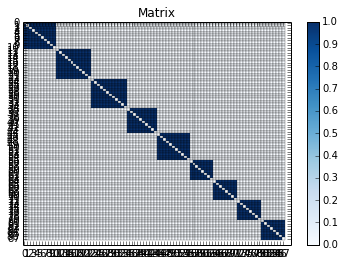

0    0.466361
1    0.388904
dtype: float64

,Value
p(same-library | truly same-library),1
p(different-library | truly different-library),1
Rand index,1


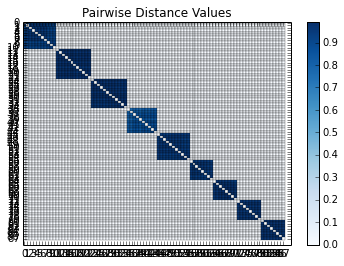

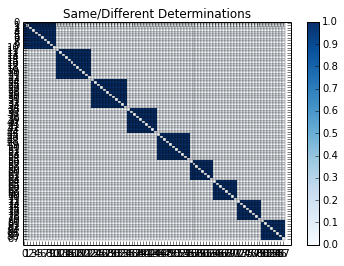

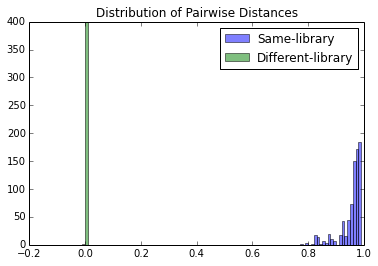

0    0.029281
1    0.037555
dtype: float64

,Value
p(same-library | truly same-library),1
p(different-library | truly different-library),1
Rand index,1


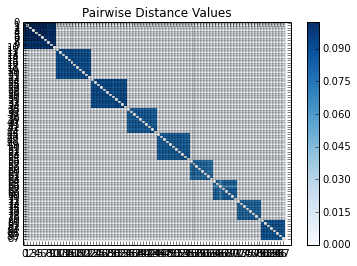

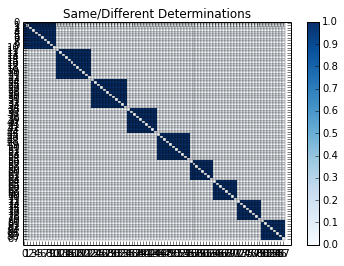

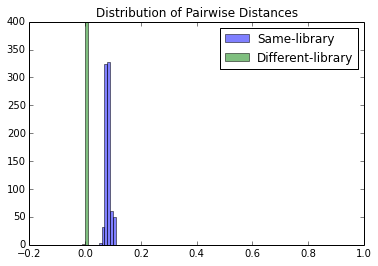

0    0.128537
1    0.080671
dtype: float64

,Value
p(same-library | truly same-library),1
p(different-library | truly different-library),1
Rand index,1


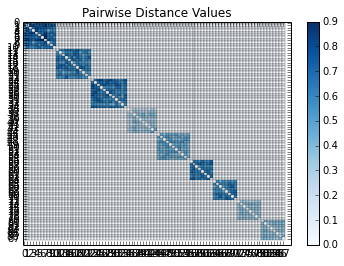

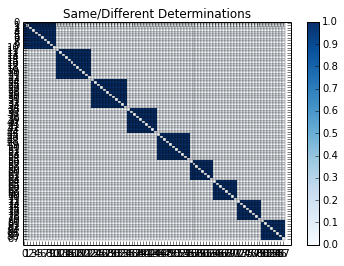

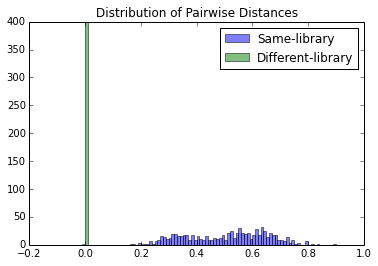

0    0.116427
1    0.069210
dtype: float64

,Value
p(same-library | truly same-library),1
p(different-library | truly different-library),1
Rand index,1


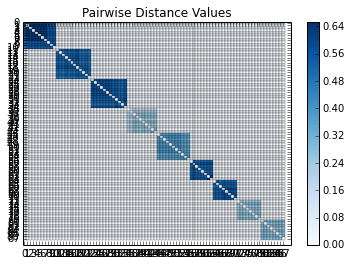

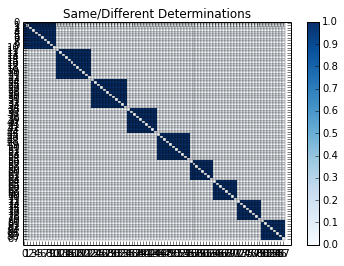

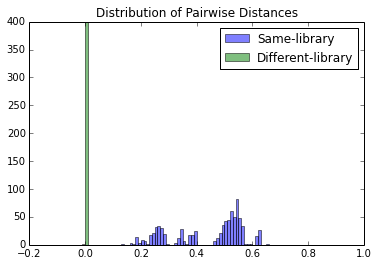

0    0.466361
1    0.388904
dtype: float64

,Value
p(same-library | truly same-library),1
p(different-library | truly different-library),1
Rand index,1


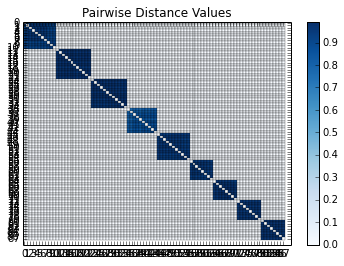

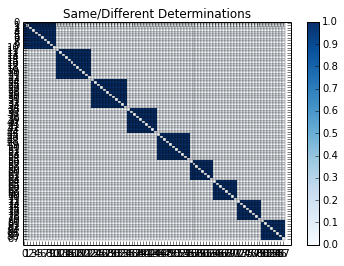

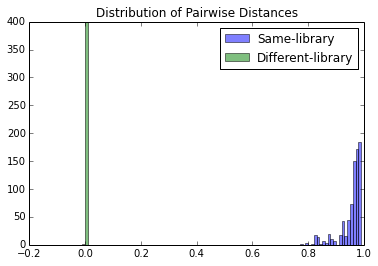

0    0.164128
1    0.102537
dtype: float64

,Value
p(same-library | truly same-library),1
p(different-library | truly different-library),1
Rand index,1


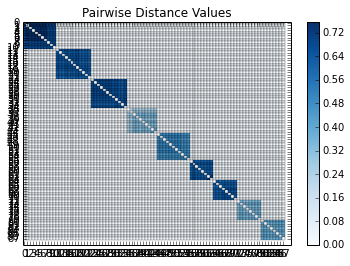

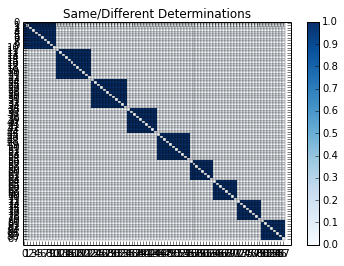

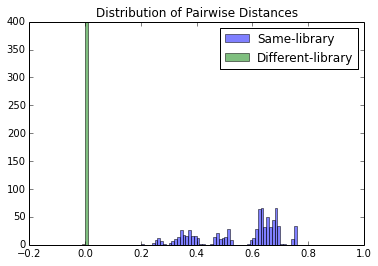

0    0.197309
1    0.126143
dtype: float64

,Value
p(same-library | truly same-library),1
p(different-library | truly different-library),1
Rand index,1


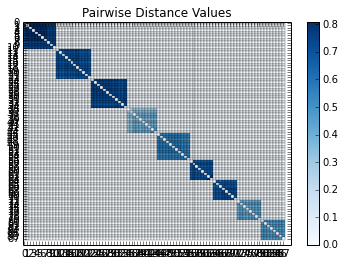

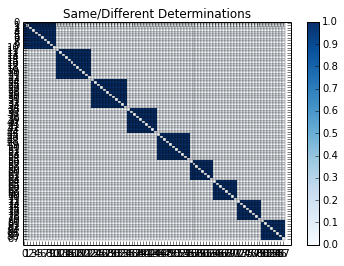

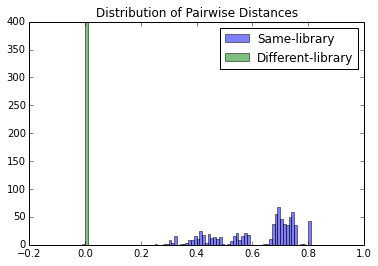

0    0.153115
1    0.093589
dtype: float64

,Value
p(same-library | truly same-library),1
p(different-library | truly different-library),1
Rand index,1


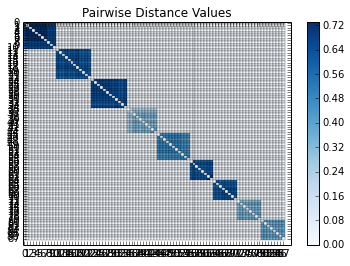

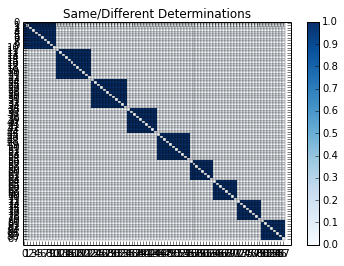

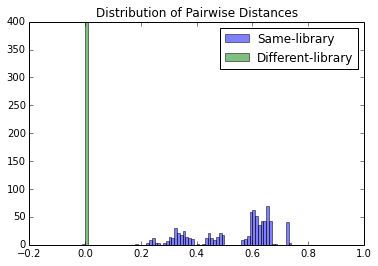

0    0.137593
1    0.082971
dtype: float64

,Value
p(same-library | truly same-library),1
p(different-library | truly different-library),1
Rand index,1


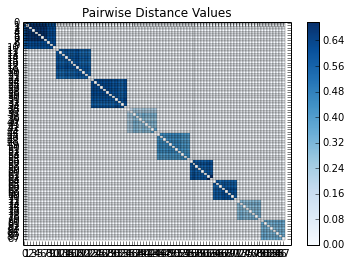

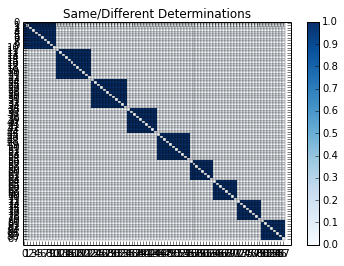

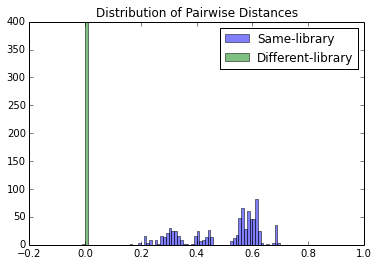

0    0.116427
1    0.069210
dtype: float64

,Value
p(same-library | truly same-library),1
p(different-library | truly different-library),1
Rand index,1


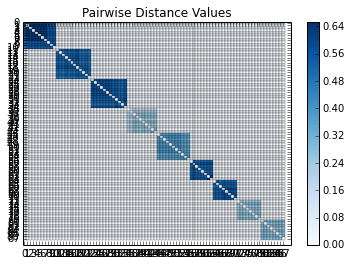

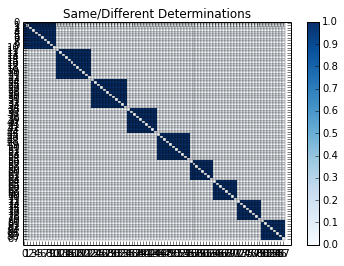

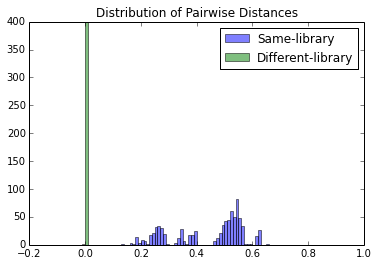

In [73]:
# Run experiment on various distance functions with a chosen descriminator, combiner (don't worry about intermediate evaluations)

# various precomputed distances from an out-of-notebook script using the same functions as above for file reading, distance computation.
#     Then calling to_csv on the resulting pandas dataframes
ten_libraries_distances = { \
              "All Pairs Affinity" : "test_10_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_10_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_10_libraries.jaccard.csv", \
              "Random Pairs Affinity" : "test_10_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_10_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_10_libraries.ten.csv", \
              "Five limited Affinity" : "test_10_libraries.five.csv", \
              "Four limited Affinity" : "test_10_libraries.four.csv", \
              "Three limited Affinity" : "test_10_libraries.three.csv", \
              "Two limited Affinity" : "test_10_libraries.two.csv" \
             }

ten_libraries_metadata = "test_10_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

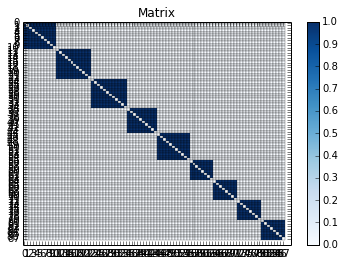

0    0.466361
1    0.388904
dtype: float64

,Value
p(same-library | truly same-library),1
p(different-library | truly different-library),1
Rand index,1


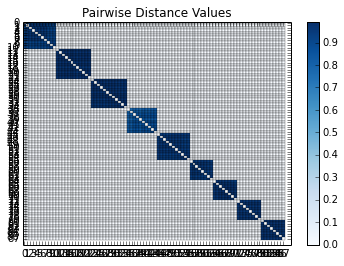

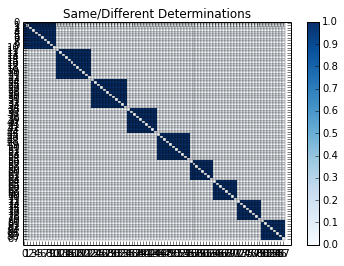

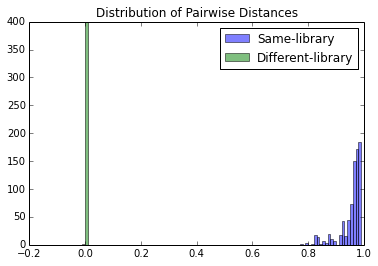

0    0.029281
1    0.037555
dtype: float64

,Value
p(same-library | truly same-library),1
p(different-library | truly different-library),1
Rand index,1


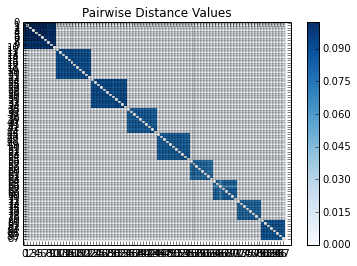

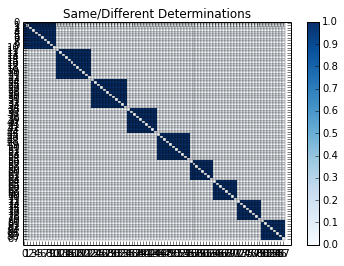

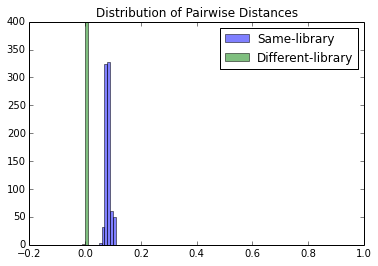

0    0.128537
1    0.080671
dtype: float64

,Value
p(same-library | truly same-library),1
p(different-library | truly different-library),1
Rand index,1


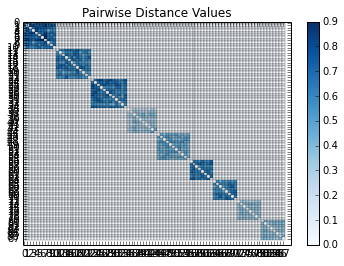

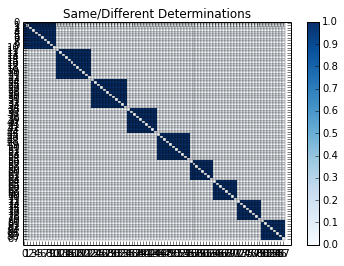

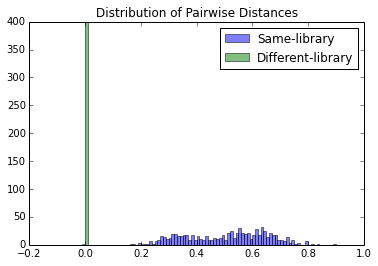

0    0.116427
1    0.069210
dtype: float64

,Value
p(same-library | truly same-library),1
p(different-library | truly different-library),1
Rand index,1


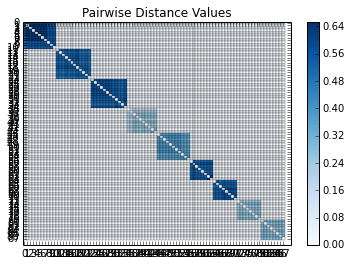

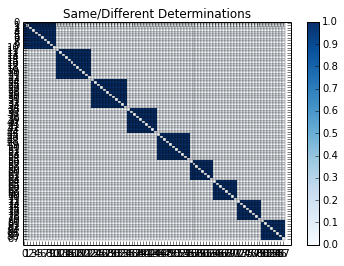

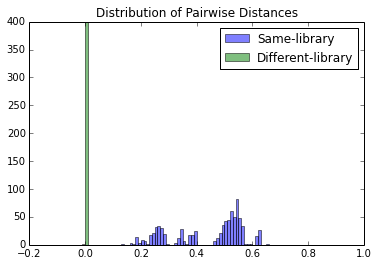

0    0.466361
1    0.388904
dtype: float64

,Value
p(same-library | truly same-library),1
p(different-library | truly different-library),1
Rand index,1


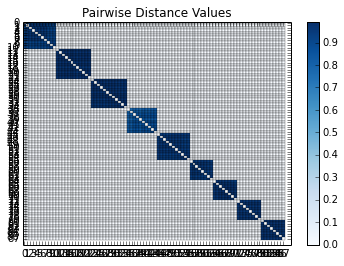

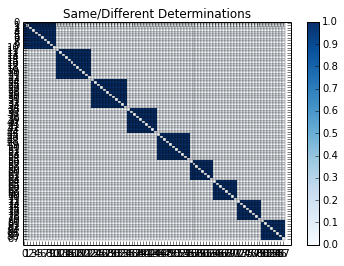

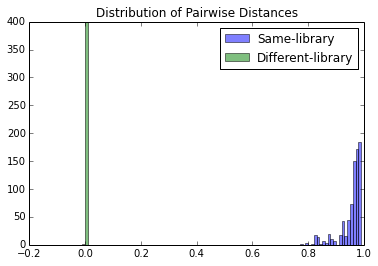

0    0.164128
1    0.102537
dtype: float64

,Value
p(same-library | truly same-library),1
p(different-library | truly different-library),1
Rand index,1


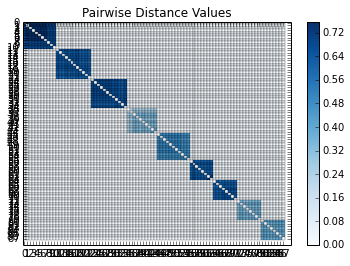

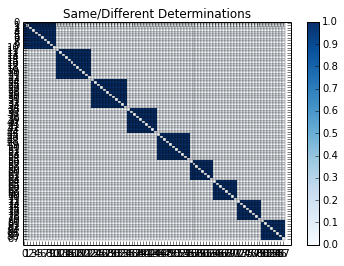

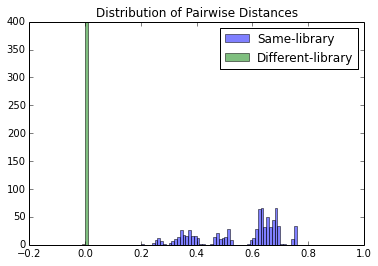

0    0.197309
1    0.126143
dtype: float64

,Value
p(same-library | truly same-library),1
p(different-library | truly different-library),1
Rand index,1


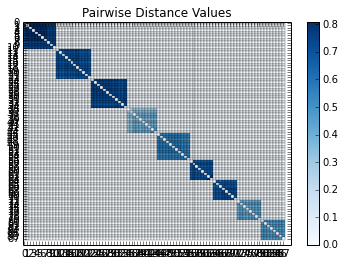

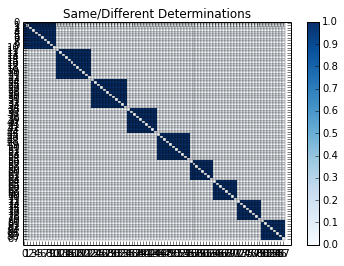

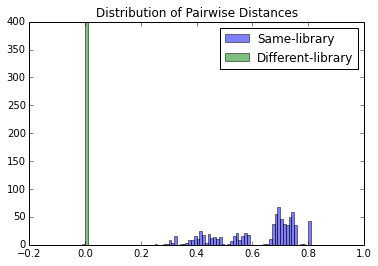

0    0.153115
1    0.093589
dtype: float64

,Value
p(same-library | truly same-library),1
p(different-library | truly different-library),1
Rand index,1


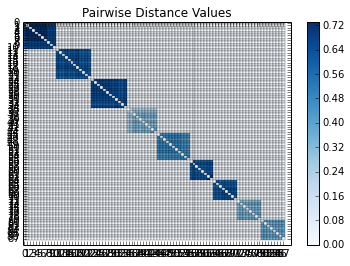

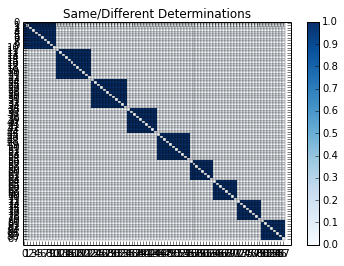

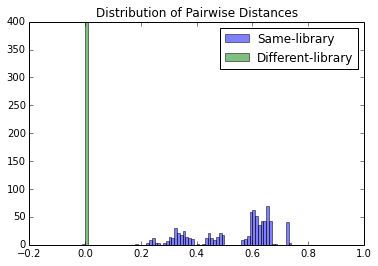

0    0.137593
1    0.082971
dtype: float64

,Value
p(same-library | truly same-library),1
p(different-library | truly different-library),1
Rand index,1


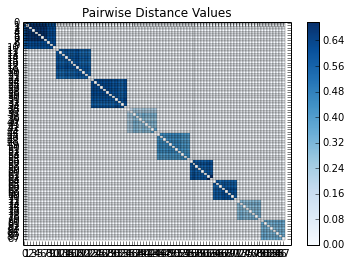

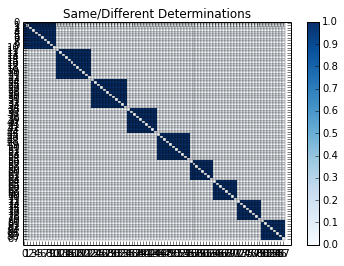

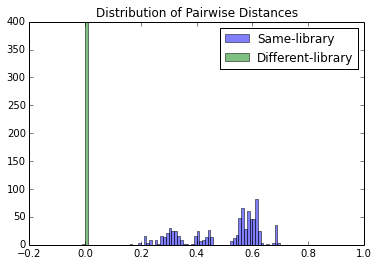

0    0.116427
1    0.069210
dtype: float64

,Value
p(same-library | truly same-library),1
p(different-library | truly different-library),1
Rand index,1


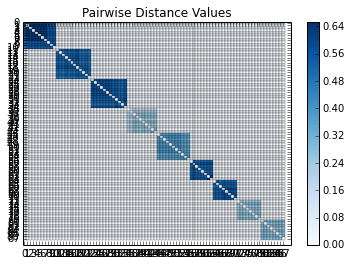

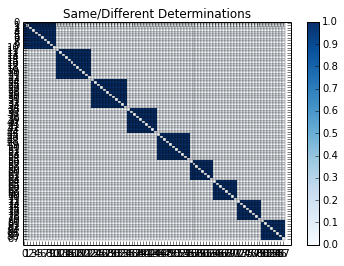

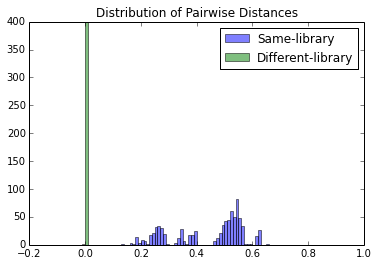

In [74]:
# Run experiment on various distance functions with a chosen descriminator, combiner (don't worry about intermediate evaluations)

# various precomputed distances from an out-of-notebook script using the same functions as above for file reading, distance computation.
#     Then calling to_csv on the resulting pandas dataframes
ten_libraries_distances = { \
              "All Pairs Affinity" : "test_10_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_10_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_10_libraries.jaccard.csv", \
              "Random Pairs Affinity" : "test_10_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_10_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_10_libraries.ten.csv", \
              "Five limited Affinity" : "test_10_libraries.five.csv", \
              "Four limited Affinity" : "test_10_libraries.four.csv", \
              "Three limited Affinity" : "test_10_libraries.three.csv", \
              "Two limited Affinity" : "test_10_libraries.two.csv" \
             }

ten_libraries_metadata = "test_10_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

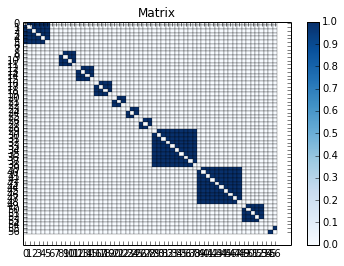

0    0.000213
1    0.171391
dtype: float64

,Value
p(same-library | truly same-library),0.965035
p(different-library | truly different-library),1.000000
Rand index,0.996867


[u'H8VK1.1', u'H8VKA.1', 0.00075596164715899998]
[u'H8VK1.1.14', u'H8VKA.1', 0.00042560816587199995]
[u'H8VK1.2', u'H8VK1.2.12', 0.084615511194899989]
[u'H8VK1.2', u'H8VKA.1', 0.00090229119048100006]
[u'H8VK1.2.12', u'H8VKA.1', 0.0079370827965100001]


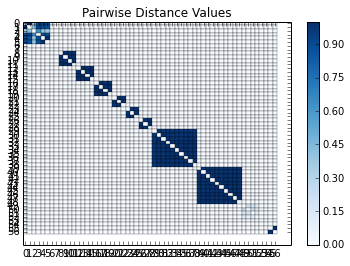

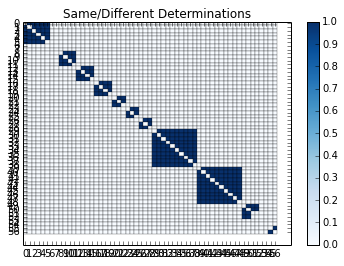

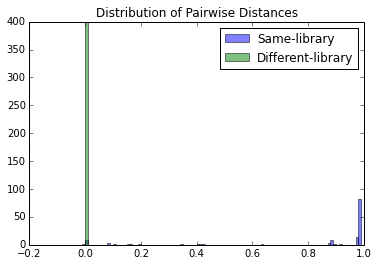

0    6.141379e-07
1    3.366593e-03
dtype: float64

,Value
p(same-library | truly same-library),0.972028
p(different-library | truly different-library),1.000000
Rand index,0.997494


[u'H8VK1.1', u'H8VKA.1', 1.22827577789e-06]
[u'H8VK1.1.14', u'H8VKA.1', 1.47363197369e-06]
[u'H8VK1.2', u'H8VKA.1', 2.2693387373900001e-06]
[u'H8VK1.2.12', u'H8VKA.1', 4.53694620669e-05]


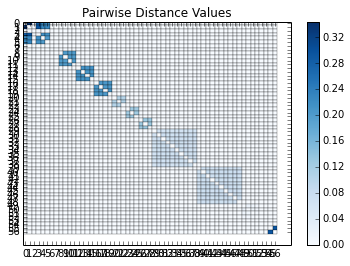

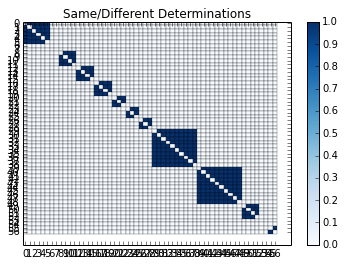

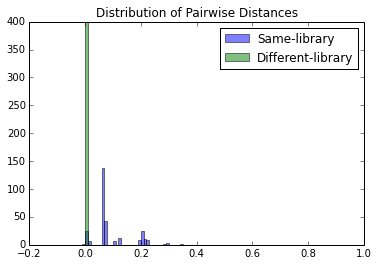

0    0.000055
1    0.245558
dtype: float64

,Value
p(same-library | truly same-library),0.930070
p(different-library | truly different-library),1.000000
Rand index,0.993734


[u'H8VK1.1', u'H8VK1.1.14', 0.0301634301025]
[u'H8VK1.1', u'H8VK1.2', 0.018157146715299999]
[u'H8VK1.1', u'H8VK1.2.12', 0.018192604693700001]
[u'H8VK1.1', u'H8VKA.1', 0.00020294098335299997]
[u'H8VK1.1.14', u'H8VK1.2', 0.018278014366400003]
[u'H8VK1.1.14', u'H8VK1.2.12', 0.0107681718244]
[u'H8VK1.1.14', u'H8VKA.1', 0.00011020681526500001]
[u'H8VK1.2', u'H8VK1.2.12', 0.013525780801600001]
[u'H8VK1.2', u'H8VKA.1', 0.00023498649530800001]
[u'H8VK1.2.12', u'H8VKA.1', 0.0088281163849400004]


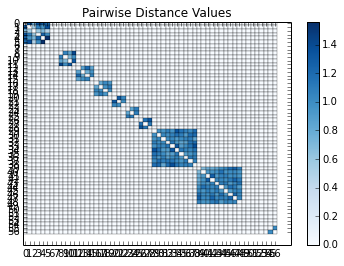

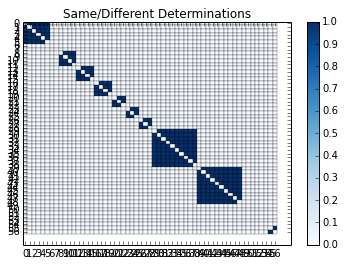

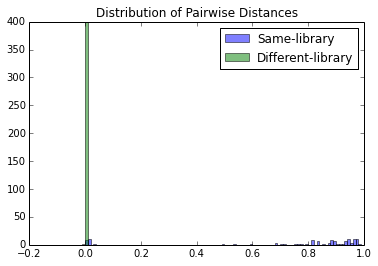

0    0.000067
1    0.440028
dtype: float64

,Value
p(same-library | truly same-library),0.930070
p(different-library | truly different-library),1.000000
Rand index,0.993734


[u'H8VK1.1', u'H8VK1.1.14', 0.017317917127799998]
[u'H8VK1.1', u'H8VK1.2', 0.0136806744789]
[u'H8VK1.1', u'H8VK1.2.12', 0.013741334531600001]
[u'H8VK1.1', u'H8VKA.1', 0.00017928719084099996]
[u'H8VK1.1.14', u'H8VK1.2', 0.011212957967999999]
[u'H8VK1.1.14', u'H8VK1.2.12', 0.011239413495300001]
[u'H8VK1.1.14', u'H8VKA.1', 0.000133643957188]
[u'H8VK1.2', u'H8VK1.2.12', 0.0089435210993700012]
[u'H8VK1.2', u'H8VKA.1', 0.000175127681886]
[u'H8VK1.2.12', u'H8VKA.1', 0.0080574779987300001]


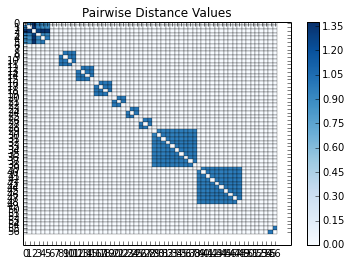

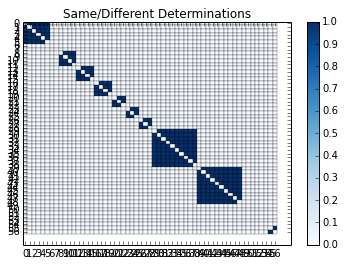

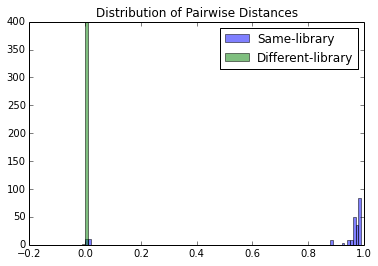

0    0.000213
1    0.171391
dtype: float64

,Value
p(same-library | truly same-library),0.965035
p(different-library | truly different-library),1.000000
Rand index,0.996867


[u'H8VK1.1', u'H8VKA.1', 0.00075596164715899998]
[u'H8VK1.1.14', u'H8VKA.1', 0.00042560816587199995]
[u'H8VK1.2', u'H8VK1.2.12', 0.084615511194899989]
[u'H8VK1.2', u'H8VKA.1', 0.00090229119048100006]
[u'H8VK1.2.12', u'H8VKA.1', 0.0079370827965100001]


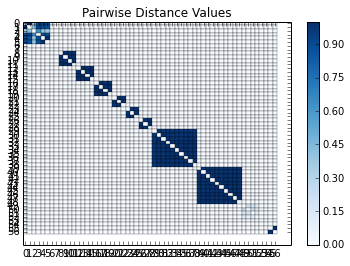

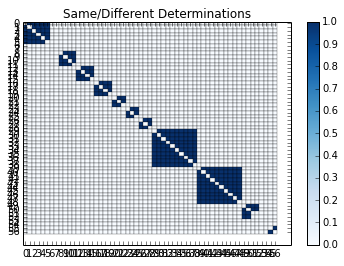

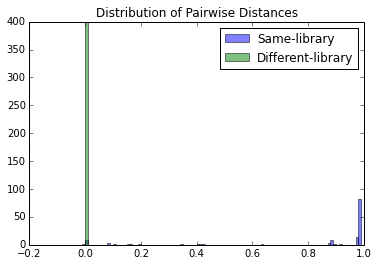

0    0.000082
1    0.192724
dtype: float64

,Value
p(same-library | truly same-library),0.930070
p(different-library | truly different-library),1.000000
Rand index,0.993734


[u'H8VK1.1', u'H8VK1.1.14', 0.033581244907500002]
[u'H8VK1.1', u'H8VK1.2', 0.025970122349200001]
[u'H8VK1.1', u'H8VK1.2.12', 0.025141620279799999]
[u'H8VK1.1', u'H8VKA.1', 0.00036914196678699993]
[u'H8VK1.1.14', u'H8VK1.2', 0.020690090015799998]
[u'H8VK1.1.14', u'H8VK1.2.12', 0.019187863775300001]
[u'H8VK1.1.14', u'H8VKA.1', 0.00016411803233300001]
[u'H8VK1.2', u'H8VK1.2.12', 0.0151506795574]
[u'H8VK1.2', u'H8VKA.1', 0.00031456589720999997]
[u'H8VK1.2.12', u'H8VKA.1', 0.0079818690413299993]


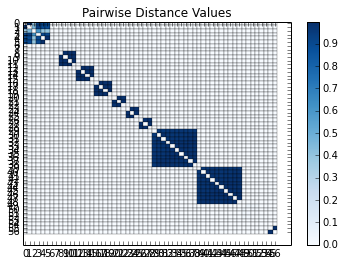

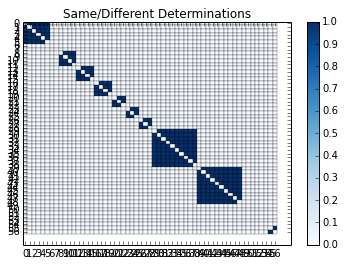

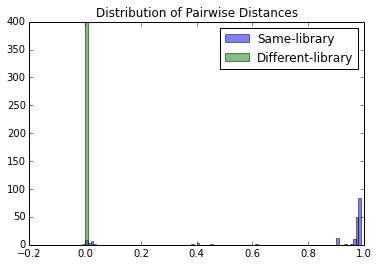

0    0.000186
1    0.169062
dtype: float64

,Value
p(same-library | truly same-library),0.930070
p(different-library | truly different-library),1.000000
Rand index,0.993734


[u'H8VK1.1', u'H8VK1.1.14', 0.047830454877600001]
[u'H8VK1.1', u'H8VK1.2', 0.037098673807500003]
[u'H8VK1.1', u'H8VK1.2.12', 0.032169733656699999]
[u'H8VK1.1', u'H8VKA.1', 0.00043252129471800006]
[u'H8VK1.1.14', u'H8VK1.2', 0.0291683261209]
[u'H8VK1.1.14', u'H8VK1.2.12', 0.024395803555799997]
[u'H8VK1.1.14', u'H8VKA.1', 0.00037102674448999997]
[u'H8VK1.2', u'H8VK1.2.12', 0.019775174569599999]
[u'H8VK1.2', u'H8VKA.1', 0.00047460121715400003]
[u'H8VK1.2.12', u'H8VKA.1', 0.0080962063921600005]


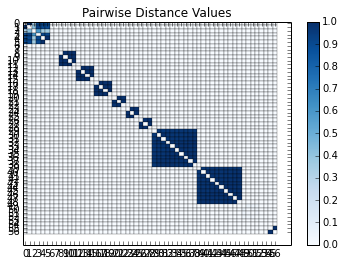

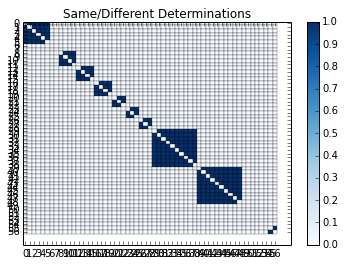

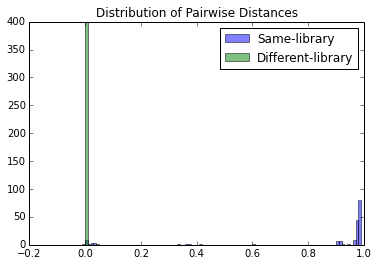

0    0.000078
1    0.208300
dtype: float64

,Value
p(same-library | truly same-library),0.930070
p(different-library | truly different-library),1.000000
Rand index,0.993734


[u'H8VK1.1', u'H8VK1.1.14', 0.028302974345299999]
[u'H8VK1.1', u'H8VK1.2', 0.022036649898799998]
[u'H8VK1.1', u'H8VK1.2.12', 0.0219689573251]
[u'H8VK1.1', u'H8VKA.1', 0.00027236725027800001]
[u'H8VK1.1.14', u'H8VK1.2', 0.017801997822499999]
[u'H8VK1.1.14', u'H8VK1.2.12', 0.0171777069495]
[u'H8VK1.1.14', u'H8VKA.1', 0.00015664025296500001]
[u'H8VK1.2', u'H8VK1.2.12', 0.0135568490396]
[u'H8VK1.2', u'H8VKA.1', 0.000269623782102]
[u'H8VK1.2.12', u'H8VKA.1', 0.0080118768047499987]


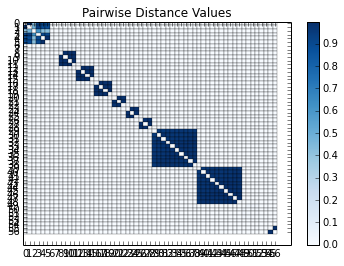

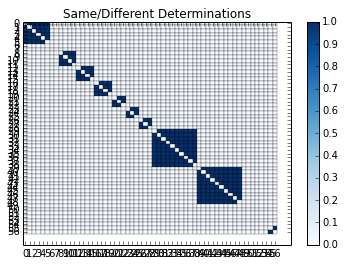

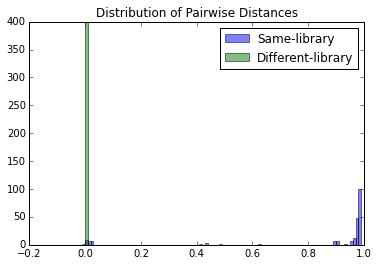

0    0.000085
1    0.248401
dtype: float64

,Value
p(same-library | truly same-library),0.930070
p(different-library | truly different-library),1.000000
Rand index,0.993734


[u'H8VK1.1', u'H8VK1.1.14', 0.022559506118799998]
[u'H8VK1.1', u'H8VK1.2', 0.017698497799599998]
[u'H8VK1.1', u'H8VK1.2.12', 0.017971834782599998]
[u'H8VK1.1', u'H8VKA.1', 0.00022170644529299999]
[u'H8VK1.1.14', u'H8VK1.2', 0.014490929435299999]
[u'H8VK1.1.14', u'H8VK1.2.12', 0.014456824560400001]
[u'H8VK1.1.14', u'H8VKA.1', 0.00016994623190499998]
[u'H8VK1.2', u'H8VK1.2.12', 0.011387805677799999]
[u'H8VK1.2', u'H8VKA.1', 0.00025160029014900003]
[u'H8VK1.2.12', u'H8VKA.1', 0.00790730614389]


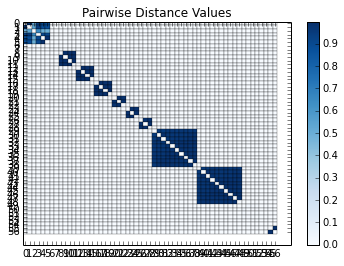

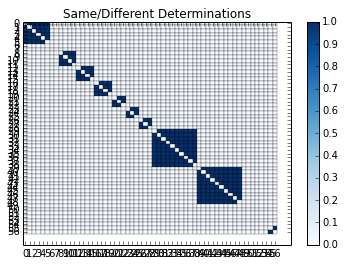

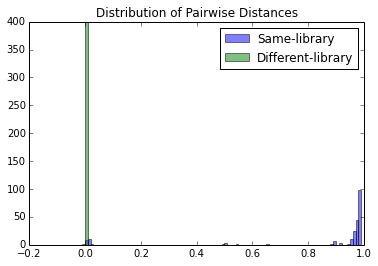

0    0.000067
1    0.440028
dtype: float64

,Value
p(same-library | truly same-library),0.930070
p(different-library | truly different-library),1.000000
Rand index,0.993734


[u'H8VK1.1', u'H8VK1.1.14', 0.017317917127799998]
[u'H8VK1.1', u'H8VK1.2', 0.0136806744789]
[u'H8VK1.1', u'H8VK1.2.12', 0.013741334531600001]
[u'H8VK1.1', u'H8VKA.1', 0.00017928719084099996]
[u'H8VK1.1.14', u'H8VK1.2', 0.011212957967999999]
[u'H8VK1.1.14', u'H8VK1.2.12', 0.011239413495300001]
[u'H8VK1.1.14', u'H8VKA.1', 0.000133643957188]
[u'H8VK1.2', u'H8VK1.2.12', 0.0089435210993700012]
[u'H8VK1.2', u'H8VKA.1', 0.000175127681886]
[u'H8VK1.2.12', u'H8VKA.1', 0.0080574779987300001]


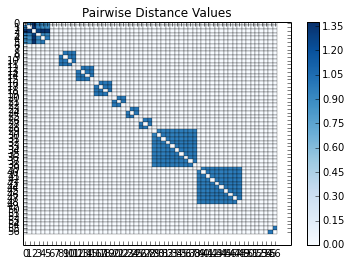

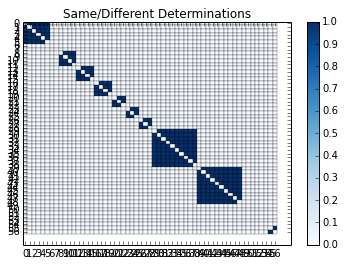

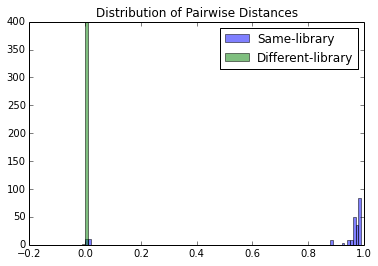

In [75]:
# Run experiment on various distance functions with a chosen descriminator, combiner (don't worry about intermediate evaluations)

# various precomputed distances from an out-of-notebook script using the same functions as above for file reading, distance computation.
#     Then calling to_csv on the resulting pandas dataframes

# Jon Blooms original data- exome libraries only

ten_libraries_distances = { \
              "All Pairs Affinity" : "test_exome_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_exome_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_exome_libraries.jaccard.csv", \
              "Random Pairs Affinity" : "test_exome_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_exome_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_exome_libraries.ten.csv", \
              "Five limited Affinity" : "test_exome_libraries.five.csv", \
              "Four limited Affinity" : "test_exome_libraries.four.csv", \
              "Three limited Affinity" : "test_exome_libraries.three.csv", \
              "Two limited Affinity" : "test_exome_libraries.two.csv" \
             }

ten_libraries_metadata = "test_exome_libraries.read_groups.json"

distances = pd.read_csv(ten_libraries_distances["Ten limited Affinity"], header=[0,1], index_col=[0,1])

np.min(distances.value[truth])

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [89]:
# Run experiment on various distance functions with a chosen descriminator, combiner (don't worry about intermediate evaluations)

# various precomputed distances from an out-of-notebook script using the same functions as above for file reading, distance computation.
#     Then calling to_csv on the resulting pandas dataframes

# Jon Blooms original data- exome libraries only

ten_libraries_distances = { \
              "All Pairs Affinity" : "test_exome_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_exome_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_exome_libraries.jaccard.csv", \
              "Random Pairs Affinity" : "test_exome_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_exome_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_exome_libraries.ten.csv", \
              "Five limited Affinity" : "test_exome_libraries.five.csv", \
              "Four limited Affinity" : "test_exome_libraries.four.csv", \
              "Three limited Affinity" : "test_exome_libraries.three.csv", \
              "Two limited Affinity" : "test_exome_libraries.two.csv" \
             }

ten_libraries_metadata = "test_exome_libraries.read_groups.json"

distances = pd.read_csv(ten_libraries_distances["All Pairs Affinity"], header=[0,1], index_col=[0,1])

meta = read_metadata(ten_libraries_metadata)
groups, libraries = get_groups_and_libraries(meta)
truth = make_truth_matrix(groups, libraries)
display(HTML("<h4>Truth Matrix</h4>"))
# plot_matrix(truth)
# plot_matrix(distances)

thold = np.mean([0.169062, 0.000186])
print thold

result = apply_threshold(distances, thold)

# print distances.get_value('B014V.6','B014V.6')

print np.max(distances.values[truth.values==0])
print np.min(distances.values[truth.values>0])
print np.min(distances.values[truth.values!=-1])
print np.max(distances.values)


def get_false_calls(distances, truth, results, groups):
    false_positives = []
    false_negatives = []
    for i in xrange(len(groups)):
        for j in xrange(i, len(groups)):
            obs = results[i, j]
            exp = truth.values[i, j]
            dist = distances.values[i,j]
            if i != j:
                if obs > exp:
                    false_positives.append([groups[i], groups[j], dist])
                elif obs < exp:
                    false_negatives.append([groups[i], groups[j], dist])
    return (false_positives, false_negatives)

false_pos, false_neg = get_false_calls(distances, truth, result, groups)
print 'False pos'
for fp in false_pos: print fp
print 'False neg:'
for fn in false_neg: print fn

0.084624
0.0
0.000425608165872
0.0
1.00138384723
False pos
False neg:
[u'H8VK1.1', u'H8VKA.1', 0.00075596164715899998]
[u'H8VK1.1.14', u'H8VKA.1', 0.00042560816587199995]
[u'H8VK1.2', u'H8VK1.2.12', 0.084615511194899989]
[u'H8VK1.2', u'H8VKA.1', 0.00090229119048100006]
[u'H8VK1.2.12', u'H8VKA.1', 0.0079370827965100001]


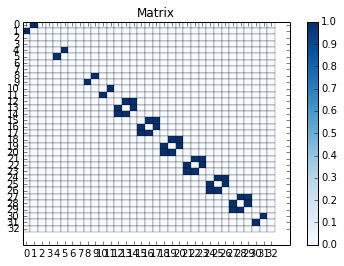

0    0.094671
1         NaN
dtype: float64

IndexError: index 33 is out of bounds for axis 1 with size 33

In [77]:
# Run experiment on various distance functions with a chosen descriminator, combiner (don't worry about intermediate evaluations)

# various precomputed distances from an out-of-notebook script using the same functions as above for file reading, distance computation.
#     Then calling to_csv on the resulting pandas dataframes

# Jon Blooms original data- exome libraries only

ten_libraries_distances = { \
              "All Pairs Affinity" : "test_weird_libraries.ap_affinity.csv", \
              "Exact Pairs Affinity" : "test_weird_libraries.ep_affinity.csv", \
              "Jaccard Similarity Index" : "test_weird_libraries.jaccard.csv", \
              "Random Pairs Affinity" : "test_weird_libraries.random.csv" , \
              "Unlimited Pairs Affinity" : "test_weird_libraries.unlimited.csv", \
              "Ten limited Affinity" : "test_weird_libraries.ten.csv", \
              "Five limited Affinity" : "test_weird_libraries.five.csv", \
              "Four limited Affinity" : "test_weird_libraries.four.csv", \
              "Three limited Affinity" : "test_weird_libraries.three.csv", \
              "Two limited Affinity" : "test_weird_libraries.two.csv" \
             }

ten_libraries_metadata = "test_weird_libraries.read_groups.json"

evaluate_all_distances(ten_libraries_distances, ten_libraries_metadata)

In [91]:
from scipy.stats import beta
from scipy.special import gamma as gammaf

distance = pd.read_csv("test_10_libraries.ap_affinity.csv", header=[0,1], index_col=[0,1])
ten_libraries_metadata = "test_10_libraries.read_groups.json"
meta = read_metadata(ten_libraries_metadata)
groups, libraries = get_groups_and_libraries(meta)
truth = make_truth_matrix(groups, libraries)
print np.max(distance.values)

def fit_beta_distributions(distance, truth):
    # Fit a beta distribution to the true positives
    true_positives=distance.values[truth.values>0].append(0)
    
    alphaT, betaT, locT, scaleT = beta.fit(true_positives, floc=0, fscale=1)
    dPos = beta(alphaT, betaT, locT, scaleT) # "freeze" the distribution parameters as an object

    # Fit a beta distribution to the true negatives
    true_negatives=distance.values[truth.values==0]
    true_negatives = true_negatives.append(1)
    alphaN, betaN, locN, scaleN = beta.fit(true_negatives, floc=0, fscale=1)
    dNeg = beta(alphaN, betaN, locN, scaleN)
    return {'positive': dPos, 'negative': dNeg}

def calculate_log_odds_ratio(x, distributions):
    dPos = distributions['positive']
    dNeg = distributions['negative']
    
    # Get the log probability that a value <= x is from positives distribution (and corresponding q)
    pSame_lib = dPos.logcdf(x) # log p(X <= x | same-library model)
    qSame_lib = dPos.logsf(x) #log 1-pSame_lib

    # Get the log probability that a value => x is from negatives distribution (and corresponding q)
    pDiff_lib = dNeg.logsf(x) # log p(X >= x | different-library model)
    qDiff_lib = dNeg.logcdf(x) # log 1-pDiff_lib

    # Compute the log odds ratio that x is from the same-library distribution
    return (pSame_lib + qDiff_lib) - (pDiff_lib + qSame_lib)

apply_log_odds = np.vectorize(calculate_log_odds_ratio)

dists = fit_beta_distributions(distance, truth)

a_true_pos = distance.iloc[0,1]
a_true_neg = distance.iloc[0,30]
LORp = calculate_log_odds_ratio(a_true_pos, dists)
LORn = calculate_log_odds_ratio(a_true_neg, dists)
print a_true_pos
print LORp
print a_true_neg
print LORn


LOR_matrix = apply_log_odds(distance, dists)
print LOR_matrix

plot_matrix(LOR_matrix)

# Plot the distribution pdfs alongside the distances historgram
dPos = dists['positive']
dNeg = dists['negative']
my_bins=np.arange(-0.01,1,.01)
true_positives=distance.values[truth.values>0]
plt.hist(true_positives, normed=True, bins=my_bins, alpha=0.5, label='Same-library') # rescale. Density?
x = np.linspace(dPos.ppf(0), dPos.ppf(0.99), 100)
plt.plot(x, dPos.pdf(x), 'r', lw=3, alpha=0.6)
plt.plot(x, dNeg.pdf(x), 'b', lw=3, alpha=0.8)
plt.show()


# Likelihood ratio test.
from scipy.stats import chisqprob
LLalt = np.log(dPos.pdf(a_true_pos)) # log likelihood that our 'same-library' distribution is the best model given x, i.e. log probability-denisity-function(x) given same-library model
LLnull = np.log(dNeg.pdf(a_true_pos)) # log likelihood that our 'different-library' distribution is the best model
LLratio = LLnull - LLalt
test_statistic = -2*LLratio # test statistic follows chi-square distribution with degrees of freedom 0 (since # parameters equal)
p_value = chisqprob(test_statistic, 0)

print LLalt
print LLnull
print LLratio
print test_statistic
print p_value

0.993000628595


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [110]:
a=np.array([10,20,30,40,3])
np.concatenate(a,np.array(50))


array([10, 20, 30, 40,  3])